Data source import complete.
Accuracy: 0.58125

Classification Report:
               precision  recall  f1-score  support
Anxiety            0.75    0.73      0.74    37.00
SuicideWatch       0.45    0.37      0.41    27.00
depression         0.53    0.66      0.59    56.00
lonely             0.71    0.50      0.59    10.00
mentalhealth       0.56    0.47      0.51    30.00
accuracy           0.58    0.58      0.58     0.58
macro avg          0.60    0.55      0.57   160.00
weighted avg       0.58    0.58      0.58   160.00


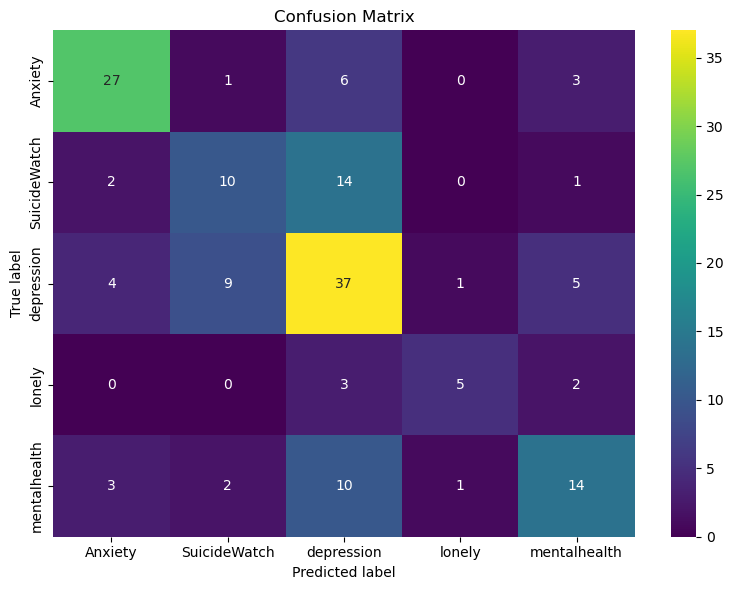


✅ Model saved to: ..\model\mental_health_model.pkl
✅ Vectorizer saved to: ..\model\mental_health_vectorizer.pkl

Model classes: ['Anxiety' 'SuicideWatch' 'depression' 'lonely' 'mentalhealth']


: 

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import re
import string
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import os

# --- Segment 0: Load and Combine Data ---
import kagglehub
entenam_reddit_mental_health_dataset_path = kagglehub.dataset_download('entenam/reddit-mental-health-dataset')

print('Data source import complete.')
# Load labelled CSVs from Kaggle Reddit Mental Health dataset
ld_da = pd.read_csv(entenam_reddit_mental_health_dataset_path + '/Original Reddit Data/Labelled Data/LD DA 1.csv')
ld_el = pd.read_csv(entenam_reddit_mental_health_dataset_path + '/Original Reddit Data/Labelled Data/LD EL1.csv')
ld_pf = pd.read_csv(entenam_reddit_mental_health_dataset_path + '/Original Reddit Data/Labelled Data/LD PF1.csv')
ld_ts = pd.read_csv(entenam_reddit_mental_health_dataset_path + '/Original Reddit Data/Labelled Data/LD TS 1.csv')

# Combine all four datasets into one
data = pd.concat([ld_da, ld_el, ld_pf, ld_ts], ignore_index=True)

# --- Segment 1: Data Cleaning and Preprocessing ---

# Drop rows missing subreddit, selftext, or title to ensure complete data
data = data.dropna(subset=['subreddit', 'selftext', 'title'])

# Combine 'selftext' and 'title' into a single 'text' field
data['text'] = data['selftext'].fillna('') + ' ' + data['title'].fillna('')

# Remove posts that are too short (less than 20 characters)
data = data[data['text'].str.len() > 20]

# Define basic text preprocessing: lowercasing, removing punctuation, normalizing spaces
def preprocess_text(text):
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub("\\s+", " ", text).strip()
    return text

# Apply preprocessing to the text data
data['text'] = data['text'].apply(preprocess_text)

# --- Segment 2: Define Features and Target ---

# Features (X) are the text posts, Target (y) is the subreddit label
X = data['text']
y = data['subreddit']

# --- Segment 3: Train-Test Split and Vectorization ---

# Split data into 80% train, 20% test, while preserving class distribution (stratify)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Initialize a TF-IDF Vectorizer (maximum 5000 words, removing English stop words)
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

# Fit vectorizer on training data and transform both train and test sets
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# --- Segment 4: Model Training ---

# Initialize Logistic Regression with balanced class weights
model = LogisticRegression(max_iter=1000, class_weight='balanced')

# Train the model on the training set
model.fit(X_train_vec, y_train)

# --- Segment 5: Evaluation ---

# Predict subreddit labels for the test set
y_pred = model.predict(X_test_vec)

# Calculate and print overall accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Generate and print detailed classification report (precision, recall, F1-score)
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print("\nClassification Report:\n", report_df.round(2))

# --- Segment 6: Visualization ---

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis',
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# --- Segment 7: Save Model and Vectorizer ---

# Create model directory if it doesn't exist
model_dir = os.path.join('..', 'model')
os.makedirs(model_dir, exist_ok=True)

# Save the trained model and vectorizer
model_path = os.path.join(model_dir, 'mental_health_model.pkl')
vectorizer_path = os.path.join(model_dir, 'mental_health_vectorizer.pkl')

joblib.dump(model, model_path)
joblib.dump(vectorizer, vectorizer_path)

print(f"\n✅ Model saved to: {model_path}")
print(f"✅ Vectorizer saved to: {vectorizer_path}")
print(f"\nModel classes: {model.classes_}")
